<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Library" data-toc-modified-id="Library-1">Library</a></span><ul class="toc-item"><li><span><a href="#Clustering-functions" data-toc-modified-id="Clustering-functions-1.1">Clustering functions</a></span></li><li><span><a href="#Plotting" data-toc-modified-id="Plotting-1.2">Plotting</a></span></li></ul></li><li><span><a href="#Example-usage" data-toc-modified-id="Example-usage-2">Example usage</a></span><ul class="toc-item"><li><span><a href="#Generate-Random-dataset" data-toc-modified-id="Generate-Random-dataset-2.1">Generate Random dataset</a></span></li><li><span><a href="#Compute-and-draw" data-toc-modified-id="Compute-and-draw-2.2">Compute and draw</a></span></li></ul></li></ul></div>

In [1]:
from collections import defaultdict

import scipy.cluster.hierarchy as sch
from matplotlib import pyplot  as plt
import matplotlib.colors as colors

import numpy as np

from sklearn.metrics import calinski_harabasz_score, silhouette_score, davies_bouldin_score

# Library

## Clustering functions

In [2]:
def iter_leaves(sons, c):
    for cc in sons[c]:
        if cc in sons:
            yield from iter_leaves(sons, cc)
        else:
            yield cc

def iter_childs(sons, c):
    yield c
    for cc in sons[c]:
        if cc in sons:
            yield from iter_childs(sons, cc)
        else:
            yield cc

def get_labels(Y, cut, sons=None):
    """
    Given a Scipy linkage table, and a distance cutoff, gives the cluster 
    labelling of each input row.
    
    :params Y: Scipy linkage table
    :params cut: distance cutoff
    :params None sons: dctionary containing the relation between 
       nodes: {mother: [daugther1, daugther2], ...}. By default it is calculated 
       from Y, but it is slower.
    
    :returns: a list of labels of each label, and also each internal node of the clustering
    """
    size = len(Y) + 1
    label = 1
    labels = [0] * (size * 2 - 1)
    if sons is None:
        sons = dict((float(c), (i, j)) for c, (i, j, d, l) in enumerate(Y, size))
    dist = dict((float(c), d) for c, (i, j, d, l) in enumerate(Y, size))
    for c in sons:
        if dist[c] > cut:
            for cc in sons[c]:
                if not cc in sons:
                    labels[int(cc)] = label
                    label += 1
                elif dist[cc] < cut:
                    for ccc in iter_childs(sons, cc):
                        labels[int(ccc)] = label
                    label += 1
    return labels

In [3]:
def best_cut(Y, sons=None, method='CH'):
    """
    Applies one of the available metric to find the best clustring of your data
    
    :param method: one of 'CH' (Calinski-Harabasz), 'silhouette' or 'DB' (Davies-Bouldin)
    """
    if method == 'CH':
        method = calinski_harabasz_score
    elif method == 'silhouette':
        method = silhouette_score
    elif method == 'DB':
        method = davies_bouldin_score
    else:
        raise NotImplementedError(method)
    size = len(Y) + 1
    if sons is None:
        sons = dict((float(c), (i, j)) for c, (i, j, d, l) in enumerate(Y, size))
    results = []
    for c in [i[2] * 1.0000001 for i in Y if i[3] != 2][:-1]:
        labels = get_labels(Y, c, sons)[:size - 1]
        # we want on average at least 4 nodes per cluster
        if len(set(labels)) >= size * 0.25:
            continue
        if len(set(labels)) <= 5:
            continue
        results.append((method(Y, labels), c))
    cut = max(results)[1]
    return cut

In [74]:
def resample_cells(m, size):
    """
    bootstrap on 20% of the cells in the matrix (assuming symmetric matrix)
    """
    x1 = np.random.randint(0, size, int(size ** 2 / 10))
    y1 = np.random.randint(0, size, int(size ** 2 / 10))
    x2 = np.random.randint(0, size, int(size ** 2 / 10))
    y2 = np.random.randint(0, size, int(size ** 2 / 10))
    m2 = m.copy()
    m2[x2, y2] = m2[x1, y1]
    m2[y2, x2] = m2[x1, y1]
    return m2


def resample_columns(m, size):
    """
    bootstrap on 20% of the columns in the matrix
    """
    x = np.random.randint(0, size, int(size / 5))
    y = np.random.randint(0, size, int(size / 5))
    m2 = m.copy()
    m2[:,y] = m2[:,x]
    return m2

In [71]:
def bootstrap(m, ori_Y, cl_method='ward', metric='euclidean', n=10000, p=0.9, 
              color_descendants=False, resample=resample_cells):
    """
    :param m: distance matrix (np.array)
    :param ori_Y:
    
    :returns: dictionary of colors
    """
    size = len(m)
    ori_sons = dict((float(c), (i, j)) for c, (i, j, d, l) in enumerate(ori_Y, size))
    ori_dad = {}
    for c, (i, j) in ori_sons.items():
        ori_dad[i] = c
        ori_dad[j] = c
    bootstrap = defaultdict(int)
    dady = {}
    for a in ori_sons:
        dady[tuple(sorted(iter_leaves(ori_sons, a)))] = a
    for _ in range(n):
        Y = sch.linkage(resample(m, size), method=cl_method, metric=metric)
        sons = dict((float(c), (i, j)) for c, (i, j, d, l) in enumerate(Y, size))
        for s in sons:
            bootstrap[tuple(sorted(iter_leaves(sons, s)))] += 1
    labels = [0] * (size * 2)

    c = 1
    p = n * p
    for nodes in sorted(bootstrap.keys(), key=lambda x: len(x), reverse=False):
        try:
            ori_node = int(max(iter_childs(ori_sons, dady[nodes])))
        except KeyError:
            continue
        if bootstrap[nodes] >= p:
            try:
                if labels[int(ori_dad[ori_node])]:
                    continue
            except KeyError:  # root of the tree
                pass
            labels[ori_node] = c if color_descendants else (bootstrap[nodes] / n)
            c += 1

    if color_descendants:
        for n, c in enumerate(labels):
            try:
                sons = set([int(s) for s in ori_sons[n]])
            except KeyError:
                continue
            while True:
                len_sons = len(sons)
                for s in list(sons):
                    try:
                        for s2 in ori_sons[s]:
                            sons.add(int(s2))
                    except KeyError:
                        continue
                if len_sons == len(sons):
                    break
            for s in sons:
                if labels[s] == 0 and c:
                    labels[s] = c

        labels[size * 2 - 2] = 0
        nums = set(labels)
        nums = dict((c, n) for n, c in enumerate(nums))
        labels = [nums[l] for l in labels]
    return labels

## Plotting

In [137]:
def dendrogram(Y, axe=None, cut=None, cut_score='CH', do_bootstrap=False, 
               matrix=None, method=None, metric=None, n_bootstrap=1000,
               p_bootstrap=0.95, quality=1):
    if not axe:
        plt.figure(figsize=(12, 3))
        axe = plt.subplot(111)
    dmax = max(i[2] for i in Y)
    size = len(Y) + 1
    sons = dict((float(c), (i, j)) for c, (i, j, d, l) in enumerate(Y, size))
    pos = dict((c, (p, 0)) for p, c in enumerate(iter_leaves(sons, size * 2 - 2)))
    if cut_score == 'bootstrap':
        labels = bootstrap(matrix, Y, cl_method=method, metric=metric, n=n_bootstrap, 
                           p=p_bootstrap, color_descendants=True)
    else:
        if cut_score is not None:
            cut = best_cut(Y, sons=sons, method=cut_score)
        labels = get_labels(Y, cut, sons)
    if do_bootstrap:
        bootstrap_labels = bootstrap(matrix, Y, cl_method=method, metric=metric, n=n_bootstrap, 
                                     p=p_bootstrap, color_descendants=False)
    color_keys = ['grey'] + [c['color'] for c in plt.rcParams['axes.prop_cycle']]
    scatterx = []
    scattery = []
    scatterc = []
    norm = colors.Normalize(p_bootstrap, 1)
    for c, (i, j, d, l) in enumerate(Y, size):
        xi, yi = pos.get(i, (0, 0))
        xj, yj = pos.get(j, (0, 0))
        color = 'grey' if labels[c] == 0 else color_keys[1 + labels[c] % 10]
        axe.plot([xi, xi, xj, xj], [yi, d, d, yj], color=color, lw=1 if color == 'grey' else 2)
        if do_bootstrap:
            if bootstrap_labels[c]:
                scatterx.append((xi + xj) / 2)
                scattery.append(d)
                scatterc.append(plt.cm.bone_r(norm(bootstrap_labels[c])))
#                 axe.plot(, d, marker='o', color=plt.cm.Reds(bootstrap_labels[c]), ms=8)
        pos[c] = (xi + xj) / 2, d
        if i < size:
            axe.text(xi, -dmax * 0.01, int(i), va='top', ha='center', size=8* quality,
                     color=color, rotation=90)
        if j < size:
            axe.text(xj, -dmax * 0.01, int(j), va='top', ha='center', size=8 * quality,
                     color=color, rotation=90)
    if do_bootstrap:
        axe.scatter(scatterx, scattery, c=scatterc)
    plt.xlim(-0.5, size - 0.5)
    axe.axis('off')
    return [int(i) for i in iter_leaves(sons, size * 2 - 2)], labels[:size]

In [138]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, vcenter=None, clip=False):
        self.vcenter = vcenter
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.vcenter, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [139]:
def plot_corr_mat(D, labels=None, fig=None, vmin=None, vmax=None, vcenter=None, title='distance', 
                  normed=True, method='ward', metric='euclidean', color_threshold=0.7,
                  cut_score='CH', do_bootstrap=False, n_bootstrap=1000, p_bootstrap=0.95,
                 quality=1):
    # D = np.array([np.array(l) for l in D])
    
    # reverse and min/max normalize
    if normed:
        D = (D - D.min()) / (D.max() - D.min())
    
    # Compute and plot first dendrogram.
    if not fig:
        fig = plt.figure(figsize=(12 * quality, 15 * quality), frameon=True)
        
    ax1 = fig.add_axes([0.2, 0.70, 0.7, 0.1], frameon=True)
    
    Y = sch.linkage(D, method=method, metric=metric)
    idx1, clusters = dendrogram(
        Y, cut=color_threshold, axe=ax1, cut_score=cut_score,
        matrix=D, method=method, metric=metric, p_bootstrap=p_bootstrap,
        do_bootstrap=do_bootstrap, n_bootstrap=n_bootstrap, quality=quality)
    
    color_keys = ['grey'] + [c['color'] for c in plt.rcParams['axes.prop_cycle']]
    
    # plot matrix
    axmatrix = fig.add_axes([0.2, 0.1, 0.7, 0.6])
    D = D[idx1,:]
    D = D[:,idx1]
    if vcenter:
        midnorm = MidpointNormalize(vmin=vmin, vcenter=vcenter, vmax=vmax)
    else:
        midnorm = None
    im = axmatrix.imshow(D, vmin=vmin, vmax=vmax, norm=midnorm, cmap='coolwarm_r')
    axmatrix.set_xticks([])
    axmatrix.set_yticks(range(len(D)))
    labels = range(len(D)) if labels is None else labels
    axmatrix.set_yticklabels(list('{}      '.format(l) for l in np.array(labels)[idx1]), ha='right',
                             size=8 * quality)
    for i, l in enumerate(idx1):
        plt.text(-0.5, i, '{} '.format(l), ha='right', va='center', size=8 * quality,
                 color=color_keys[1 + clusters[l] % 10])
    axmatrix.tick_params(axis=u'both', which=u'both',length=0)
    vmin, vmax = im.get_clim()

    # colorbar
    axcolor = fig.add_axes([0.05, 0.705, 0.13, 0.05])
    plt.colorbar(im, cax=axcolor, orientation='horizontal')
    plt.xlabel(title, rotation=0, size=9 * quality)
    height, pos = np.histogram([v for l in D for v in l], bins=20, range=(vmin, vmax))
    height = (vmin + height / height.max()) * (vmax - vmin) * 0.95
    pos    = (vmin + pos    / pos.max()   ) * (vmax - vmin)
    axcolor.step(pos[:-1], height, color='white', linewidth=2)

    # colorbar2
    if do_bootstrap:
        axcolor = fig.add_axes([0.05, 0.78, 0.13, 0.015])
        norm = colors.Normalize(p_bootstrap, 1)
        sm =  plt.cm.ScalarMappable(norm=norm, cmap='bone_r')
        sm.set_array([])
        plt.colorbar(sm, cax=axcolor, orientation='horizontal')
        plt.xlabel('Bootstrap confidence', rotation=0, size=9 * quality)

    return Y, idx1, clusters

# Example usage

## Generate Random dataset

In [140]:
from sklearn.datasets import make_blobs

In [141]:
features, target = make_blobs(n_samples = 100,
                  # two feature variables,
                  n_features = 3,
                  # four clusters,
                  centers = 4,
                  # with .65 cluster standard deviation,
                  cluster_std = 3,
                  # shuffled,
                  shuffle = True)
                  
mat = np.array([np.array([((a1-a2)**2+(b1-b2)**2+(c1-c2)**2)**0.5 for a2, b2, c2 in features])
                for a1, b1, c1 in features])

labels = np.array([''.join('AdAdsdfskfbkFDSFSSHjs'[np.random.randint(0, 10)] 
                                 for i in range(np.random.randint(1, 30))) for i in range(len(mat))])

## Compute and draw

/home/fransua/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


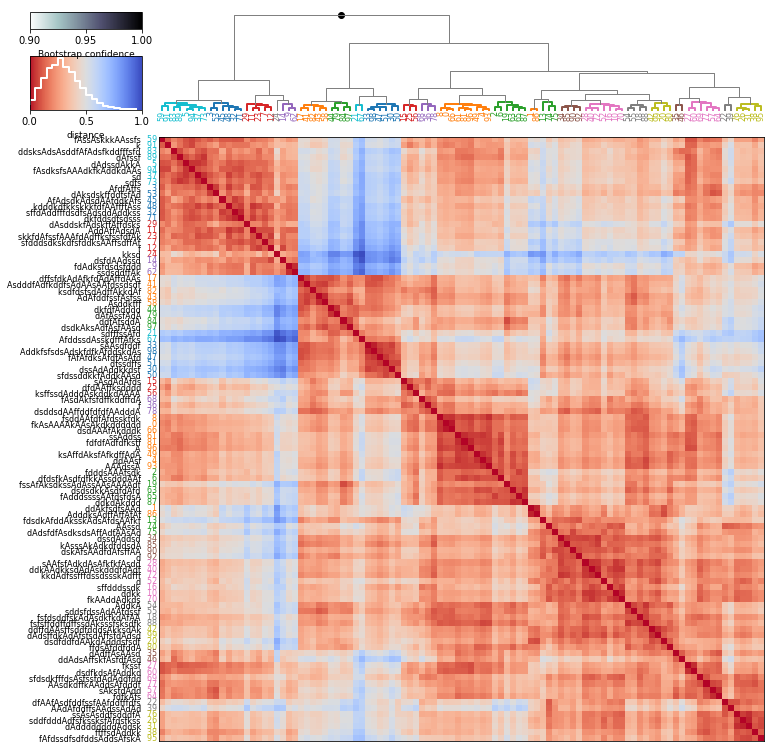

In [142]:
Y = plot_corr_mat(mat, labels=labels, normed=True, cut_score='DB', do_bootstrap=True, p_bootstrap=0.9, quality=1)

/home/fransua/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


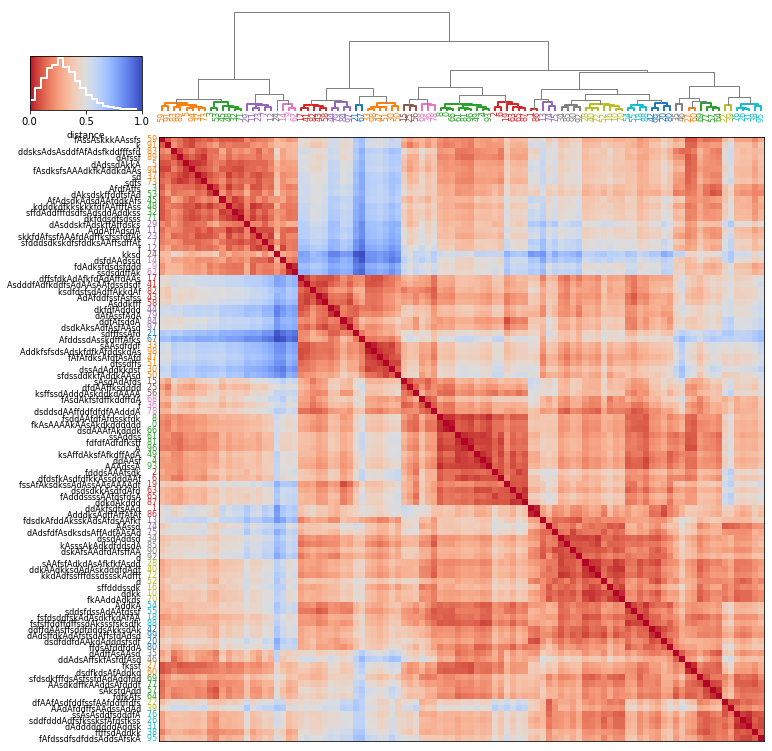

In [143]:
Y = plot_corr_mat(mat, labels=labels, normed=True, cut_score='CH')

/home/fransua/.miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  from ipykernel import kernelapp as app


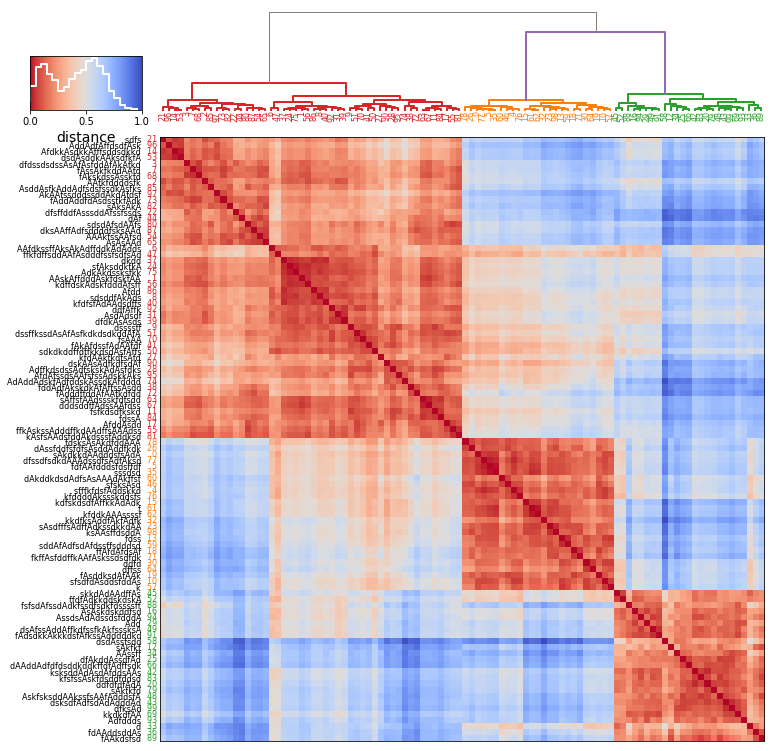

In [72]:
Y = plot_corr_mat(mat, labels=labels, normed=True, cut_score='bootstrap', p_bootstrap=0.8)